### Imports and CUDA

In [1]:
!pip uninstall -y typing_extensions
!pip install typing_extensions==4.11.0
!pip uninstall wandb -y
!pip install wandb
!pip install matplotlib
!pip install scikit-learn
!pip install pandas

Found existing installation: typing_extensions 4.12.2
Uninstalling typing_extensions-4.12.2:
  Successfully uninstalled typing_extensions-4.12.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pydantic 2.11.1 requires typing-extensions>=4.12.2, but you have typing-extensions 4.11.0 which is incompatible.
typing-inspection 0.4.0 requires typing-extensions>=4.12.0, but you have typing-extensions 4.11.0 which is incompatible.

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Found existing installation: wandb 0.19.8
Uninstalling wandb-0.19.8:
  Successfully uninstalled wandb-0.19.8
  Using cached wandb-0.19.9-py3-none-win_amd64.whl.metadata (10 kB)
  Using cached typing_extensions-4.13.2-py3-none-any.whl.metadata (3.0 kB)
Using cached wandb-0.19.9-py3-none-win_amd64.whl (20.2 MB)
Using cached typing_extensions-4.13.2-py3-none-any.whl (45 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.11.0
    Uninstalling typing_extensions-4.11.0:
      Successfully uninstalled typing_extensions-4.11.0



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Matplotlib
import requests
import matplotlib.pyplot as plt

# Numpy
import numpy as np

# Torch
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import pandas as pd

# Misc
from tqdm import tqdm
import os

### Run this if using Wandb for Hyperparameter Tuning, else do not run this

In [3]:
# import wandb
# wandb.login()

In [4]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Objective

#### To develop a model that predicts taxi availability within a specific area for the next three hours. This means that if the model is run at 12 PM, it will provide predicted taxi availability for 1 PM, 2 PM, and 3 PM.

The area of interest is defined by the following geographical boundaries:

    North: 1.35106
    South: 1.32206
    East: 103.97839
    West: 103.92805

To identify the taxis currently available within this region, we use the TaxiAvailabilityScript.py.

This script collects real-time data, which serves as input for our predictive model.

By leveraging historical taxi availability trends and real-time data, our model aims to provide accurate forecasts, helping commuters, ride-hailing services, and urban planners make informed decisions.


# **To-Do List for Taxi Availability Prediction**

## **Step 1: Cleaning the Taxi Availability Data**
The first step involves retrieving and preprocessing the taxi availability dataset. The dataset consists of the following columns:

1. **DateTime**  
2. **Taxi Available Throughout Singapore**  
3. **Taxi Available in Selected Box Area**  
4. **Coordinates[]**  

For our specific use case, **the coordinates column will not be used for now**.  

To prepare the data for the neural network:  
- **Inputs:** We will use `DateTime` and `Taxi Available Throughout Singapore` as features.  
- **Output:** `Taxi Available in Selected Box Area` will be the target variable.  
- **DateTime Conversion:** Since `DateTime` is not in a format suitable for neural networks, we will extract relevant features:
  - **IsWeekend**: A binary feature (1 if it's a weekend, 0 otherwise).  
  - **Hour**: Transformed into a numerical value between **1 and 24** (avoiding 0, which may cause training issues).  

---

## **Step 2: Adding Additional Features**  
*(Partially completed; will be refined over time)*  

Aside from the existing columns, we aim to incorporate additional features that may improve prediction accuracy:  

1. **ERP Rates (Electronic Road Pricing) at the given time and location**  
   - Uncertain if this will significantly impact predictions. Further analysis is needed.  

2. **Number of LTA (Land Transport Authority) gantry locations**  
   - Again, its usefulness remains uncertain—further evaluation required.  

3. **Traffic Incidents in the Selected Area**  
   - A script (`TrafficIncidentScript.py`) has been written to update `traffic_incident.csv` with the latest traffic incidents.  
   - Over time, as the dataset grows, we hope this feature will become useful.  

4. **Number of Taxi Stands in the Area**  
   - Currently **not useful** because our area of interest is fixed.  
   - However, if we allow dynamic selection of areas in the future, this could become relevant.  

5. **Temperature at a Given Time and Date** *(To be implemented)*  

6. **Rainfall Data** *(To be implemented)*  

To ensure all features align properly, we will **synchronize all datasets based on DateTime** before feeding them into the model.  

---

## **Step 3: Creating the Training-Test Split**  
- Initially, we will perform an **80/20 Training-Test split** for simplicity.  
- In the future, we may introduce a **Training-Validation-Test split** to further refine model performance.  

---

## **Step 4: Building the Model**  
We will begin with an **LSTM model**, as LSTMs are well-suited for time-series forecasting.  
- **Initial Limitation:** The model, in its basic form, will only predict the next hour.  
- **Future Improvement:** A **sliding window approach** will be explored and implemented to extend predictions further.  

---

## **Step 5: Model Evaluation and Improvement**  
- After the initial model is trained, we will assess its performance.  
- Based on results, we will explore potential improvements, such as hyperparameter tuning, architectural modifications, or additional feature engineering.  

---

This structured approach will guide the development of a robust and accurate taxi availability prediction model. 🚖💡


## **Preparing the taxi_availability data here.**

Normalization of certain inputs are done as well, but I am unsure if it is the right thing to do as well.

In [5]:
merged_weather_taxi_df = "merged_file_with_mean.csv"
taxi_df = pd.read_csv(merged_weather_taxi_df, delimiter = ",")

#Adjusting for weather parameters
taxi_df = taxi_df.drop(columns = "stationId")

#Adjusting for taxi_vailability parameters
taxi_df_coordinates = taxi_df["Coordinates[]"]
taxt_df_datetime = taxi_df["DateTime"]
taxi_df = taxi_df.drop(columns = "Coordinates[]")
taxi_df["DateTime"] = pd.to_datetime(taxi_df["DateTime"])
taxi_df = taxi_df.drop(columns = "Taxi Available in Selected Box Area")

taxi_df["IsWeekend"] = (taxi_df["DateTime"].dt.weekday >= 5).astype(int)
taxi_df["Hour"] = taxi_df["DateTime"].dt.hour + 1  # Convert 0-23 to 1-24
taxi_df = taxi_df.drop(columns = "DateTime")

print(taxi_df.head)

<bound method NDFrame.head of        Taxi Available throughout SG  temp_value  humidity_value  \
0                              1924        27.1            84.1   
1                              2259        27.3            82.5   
2                              2400        27.4            81.2   
3                              2677        27.5            81.9   
4                              2437        27.7            78.0   
...                             ...         ...             ...   
25586                          1962        27.0            82.9   
25587                          2025        27.3            81.7   
25588                          2144        27.4            82.2   
25589                          2447        27.3            82.9   
25590                          2615        27.6            82.3   

       rainfall_value  peak_period  Average Taxi Availability  IsWeekend  Hour  
0                 0.0            1                 102.416667          0    24  
1  

### Converting all dtypes into float32

In [6]:
numeric_columns = taxi_df.select_dtypes(include=['int64', 'int32','float64','object']).columns
print("numeric_columns",numeric_columns)
taxi_df[numeric_columns] = taxi_df[numeric_columns].astype('float32')
numeric_columns = taxi_df.select_dtypes(include=['int64', 'int32','float64','object']).columns

# Convert selected columns to float32
taxi_df[numeric_columns] = taxi_df[numeric_columns].astype('float32')

numeric_columns Index(['Taxi Available throughout SG', 'temp_value', 'humidity_value',
       'rainfall_value', 'peak_period', 'Average Taxi Availability',
       'IsWeekend', 'Hour'],
      dtype='object')


### Normalizing all values

In [7]:
#---------------Normalise-----------------------
data_min = taxi_df.min(axis=0)
data_max = taxi_df.max(axis=0)
taxi_df_normalized = (taxi_df - data_min) / (data_max - data_min)


taxi_df_output_normalized  = taxi_df_normalized["Average Taxi Availability"]
taxi_df_normalized.to_csv("normalized_data.csv", index=False)  # Set index=False to exclude row numbers

# Convert to NumPy arrays
input_data = taxi_df_normalized.values  # Shape: (5120, num_features)
output_data = taxi_df_output_normalized.values  # Shape: (5120,)

print("Input Data: ",input_data.shape)
print("Output Data: ",output_data.shape)

Input Data:  (25591, 8)
Output Data:  (25591,)


### Create Sequence Function

In [8]:
seq_length = 24
pred_horizon = 3  # Number of future time steps to predict

def create_sequences(data, labels, seq_length, pred_horizon):
    xs, ys = [], []
    for i in range(0, len(data), seq_length):  # Start from 0 and increment by seq_length
        if i + seq_length + pred_horizon <= len(data):  # Ensure enough data for prediction horizon
            xs.append(data[i:i + seq_length])  # Input sequence (continuous)
            ys.append(labels[i + seq_length : i + seq_length + pred_horizon])  # Next 3 values
    return np.array(xs), np.array(ys)

In [9]:
X, y = create_sequences(input_data, output_data, seq_length,pred_horizon)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y[:, None], dtype=torch.float32)
y = y.permute(0, 2, 1)  # Shape: (samples, pred_horizon, 1)

# Split sizes
total_samples = len(X)
train_size = int(0.8 * total_samples)
val_size = int(0.1 * total_samples)
test_size = total_samples - train_size - val_size

# Split the data
trainX, valX, testX = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
trainY, valY, testY = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

# Create TensorDatasets
train_dataset = TensorDataset(trainX, trainY)
val_dataset = TensorDataset(valX, valY)
test_dataset = TensorDataset(testX, testY)

# DataLoaders
batch_size = 17
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Example of accessing a batch of data
for inputs, targets in train_loader:
    print(f'Inputs: {inputs.shape}, Targets: {targets.shape}')
    break  # Only print the first batch for verification

Inputs: torch.Size([17, 24, 8]), Targets: torch.Size([17, 3, 1])


Using a bidirectional LSTM as the encoder

In [10]:
class BiEncoderLSTM(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(BiEncoderLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_directions = 2  # Since it's bidirectional
        
        # LSTM layer
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
    def forward(self, inputs):

        inputs = inputs.to(device)
        out, (hn, cn) = self.lstm(inputs)
        hn_dec = hn[0] + hn[1]
        cn_dec = cn[0] + cn[1]

        hn_dec = hn_dec.unsqueeze(0)
        cn_dec = cn_dec.unsqueeze(0)

        return hn_dec, cn_dec


In [11]:
class DecoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(DecoderLSTM, self).__init__()


        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)

        # Implementing Prof Idea
        self.linear1 = nn.Linear(hidden_size, 1)
        self.linearsub1 = nn.Linear(hidden_size, input_size)

        self.linear2 = nn.Linear(hidden_size, 1)
        self.linearsub2 = nn.Linear(hidden_size, input_size)

        self.linear3 = nn.Linear(hidden_size, 1)

    def forward(self, x, hidden,):
        outputs = []
        decoder_input = x
        
        # First LSTM layer
        decoder_input = decoder_input.to(device)
        y1, hidden1 = self.lstm(decoder_input, hidden)
        linear_y1 = self.linear1(y1)
        linear_y1 = linear_y1.mean(dim=1, keepdim=True)
        linear_suby1 = self.linearsub1(y1)

        # Second LSTM layer
        y2, hidden2 = self.lstm(linear_suby1, hidden)
        linear_y2 = self.linear2(y2)
        linear_suby2 = self.linearsub2(y2)
        linear_y2 = linear_y2.mean(dim=1, keepdim=True)

        y3, hidden3 = self.lstm(linear_suby2, hidden)
        linear_y3 = self.linear3(y3)
        linear_y3 = linear_y3.mean(dim=1, keepdim=True)

        outputs.append(linear_y1.squeeze(1))  # shape: [17, 1]
        outputs.append(linear_y2.squeeze(1))
        outputs.append(linear_y3.squeeze(1))

        final_output = torch.stack(outputs, dim=1)  # [17, 3, 1]
        return final_output

In [12]:
class Seq2Seq(nn.Module):
    def __init__(self, hidden_size, output_size, input_size):
        super(Seq2Seq, self).__init__()
        self.output_length = output_size
        self.encoder = BiEncoderLSTM(input_size, hidden_size) 
        self.decoder = DecoderLSTM(input_size, hidden_size)
        
    def forward(self, inputs, outputs=None):

        # Encode the input sequence
        inputs = inputs.to(device)
        hidden = self.encoder(inputs)  # Get encoded hidden state from the encoder

        # Initialize decoder input (usually last input value or a special token)
        decoder_input = inputs
        # Decode the sequence
        output = self.decoder(decoder_input, hidden)
        return output

In [13]:
def train(dataloader, val_loader, model, num_epochs, learning_rate):
    # Set the model to training mode
    model.train()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    loss_graph = []  # Initialize a list to store loss values
    val_graph = []

    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, outputs in dataloader:
            inputs = inputs.to(device)
            outputs = outputs.to(device)

            # Clear previous gradients
            optimizer.zero_grad()
            # Forward pass
            pred = model(inputs, outputs)
            # Calculate loss
            pred = pred.to(device)

            loss = criterion(pred, outputs)
            total_loss += loss.item()
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        # Append the average loss for this epoch to the loss_graph list
        loss_graph.append(total_loss / len(dataloader))

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_inputs, val_outputs in val_loader:
                val_inputs = val_inputs.to(device)
                val_outputs = val_outputs.to(device)
                val_pred = model(val_inputs, val_outputs)
                val_loss += criterion(val_pred, val_outputs).item()
        avg_val_loss = val_loss / len(val_loader)
        val_graph.append(avg_val_loss)
        model.train()

        # Print total loss every few epochs
        if epoch % 25 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, Avg Loss: {total_loss / len(dataloader)}, Avg Val Loss: {avg_val_loss}')

    return loss_graph, val_graph  # Return the loss graph to plot it later

Epoch 1/50, Avg Loss: 0.01926277026999742, Avg Val Loss: 0.014388779178261757
Epoch 26/50, Avg Loss: 0.003703001639805734, Avg Val Loss: 0.005513541167601943


Text(0, 0.5, 'Loss')

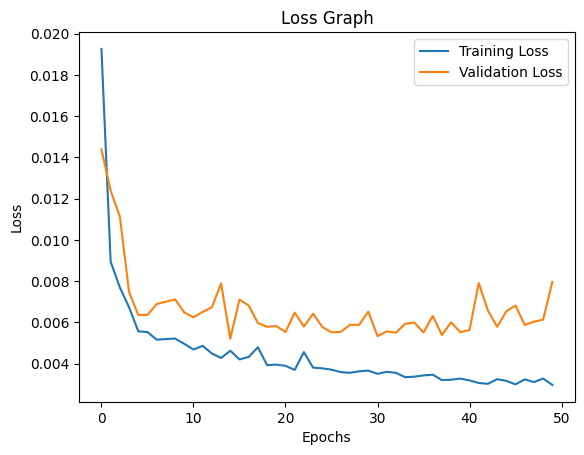

In [14]:
# Hyperparameters
input_size = 8
hidden_size = 256
output_size = 3
learning_rate = 1e-3
num_epochs = 50

dataloader = train_loader

# Initialize Seq2Seq Model
seq2seq_model = Seq2Seq(hidden_size = hidden_size, output_size = output_size, input_size=input_size).to(device)

# Train the model
loss_graph, val_graph = train(dataloader = dataloader, val_loader = val_loader, model = seq2seq_model, num_epochs = num_epochs, learning_rate = learning_rate)

# Plot the loss graph
plt.plot(loss_graph)
plt.plot(val_graph)
plt.title("Loss Graph")
plt.legend(["Training Loss","Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")

### The next 3 cells are used for Hyper Parameter Sweeping using Wandb. Do not run these cells unless you are logged into Wandb and is doing hyper parameter sweep

In [15]:
# sweep_config = {
#     "method": "bayes",
#     "metric": {
#         "name": "val_loss",
#         "goal": "minimize"
#     },
#     "parameters": {
#         "learning_rate": {
#             "min": 1e-3,
#             "max": 0.01
#         },
#         "hidden_size": {
#             "values": [64, 128, 256]
#         },
#         "num_epochs": {
#             "values": [300, 500, 1000]
#         }
#     }
# }

In [16]:
# def sweep_train():
#     # Initialize W&B
#     wandb.init()
#     config = wandb.config

#     model = Seq2Seq(
#         hidden_size=config.hidden_size,
#         output_size=3,
#         input_size=8
#     ).to(device)
#     criterion = nn.MSELoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

#     loss_graph = []
#     val_graph = []

#     model.train()
#     for epoch in tqdm(range(config.num_epochs)):
#         total_loss = 0
#         for inputs, outputs in dataloader:
#             inputs, outputs = inputs.to(device), outputs.to(device)

#             optimizer.zero_grad()
#             pred = model(inputs, outputs)
#             pred = pred.to(device)

#             loss = criterion(pred, outputs)
#             total_loss += loss.item()
#             loss.backward()
#             optimizer.step()

#         avg_loss = total_loss / len(dataloader)
#         loss_graph.append(avg_loss)

#         # Validation
#         model.eval()
#         val_loss = 0
#         with torch.no_grad():
#             for val_inputs, val_outputs in val_loader:
#                 val_inputs, val_outputs = val_inputs.to(device), val_outputs.to(device)
#                 val_pred = model(val_inputs, val_outputs)
#                 val_loss += criterion(val_pred, val_outputs).item()

#         avg_val_loss = val_loss / len(val_loader)
#         val_graph.append(avg_val_loss)
#         model.train()

#         # Log to wandb
#         wandb.log({
#             "epoch": epoch,
#             "train_loss": avg_loss,
#             "val_loss": avg_val_loss
#         })

#         if epoch % 25 == 0:
#             print(f"Epoch {epoch+1}/{config.num_epochs}, Train Loss: {avg_loss}, Val Loss: {avg_val_loss}")

#     return loss_graph, val_graph


In [17]:
# sweep_id = wandb.sweep(sweep_config, project="DeepLearning Project")
# wandb.agent(sweep_id, function=sweep_train, count=30)

### The next 2 cells are used to save the last ran model and to load models. Do not run unless you are saving or loading models from file.

In [18]:
import os

# Create the 'models' directory if it doesn't exist
os.makedirs('./final_models', exist_ok=True)
torch.save(seq2seq_model.state_dict(), './final_models/Bi-ED-LSTM.pth')

In [20]:
import random

input_size = 8
hidden_size = 256
output_size = 3

# Initialize Seq2Seq Model
seq2seq_model = Seq2Seq(hidden_size = hidden_size, output_size = output_size, input_size=input_size).to(device)
seq2seq_model.load_state_dict(torch.load('./final_models/Bi-ED-LSTM.pth'))
seed_value = random.randint(0, 10000)

### The final cell here is used for evaluation

tensor(18.0119, device='cuda:0')
Normalized output[0]: [[0.2378053516149521], [0.2418629378080368], [0.25599589943885803]]
Normalized target[0]: [[0.15392456948757172], [0.10669384896755219], [0.156642884016037]]
Denormalized output[0]: [[58.32176208496094], [59.31688690185547], [62.78299331665039]]
Denormalized target[0]: [[37.75], [26.16666603088379], [38.41666793823242]]
--------------------------------------------------
tensor(16.9270, device='cuda:0')
Normalized output[0]: [[0.3157176375389099], [0.32431888580322266], [0.356317400932312]]
Normalized target[0]: [[0.2721712589263916], [0.2453279048204422], [0.22799864411354065]]
Denormalized output[0]: [[77.42974853515625], [79.5392074584961], [87.3868408203125]]
Denormalized target[0]: [[66.75], [60.16666793823242], [55.91666793823242]]
--------------------------------------------------
tensor(15.4544, device='cuda:0')
Normalized output[0]: [[0.465930700302124], [0.4487111568450928], [0.44039201736450195]]
Normalized target[0]: [[0

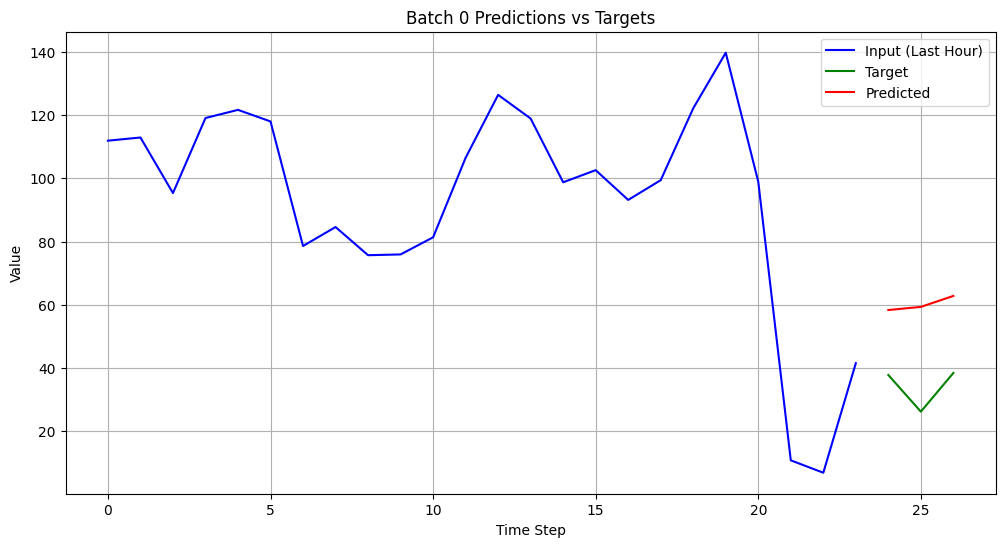

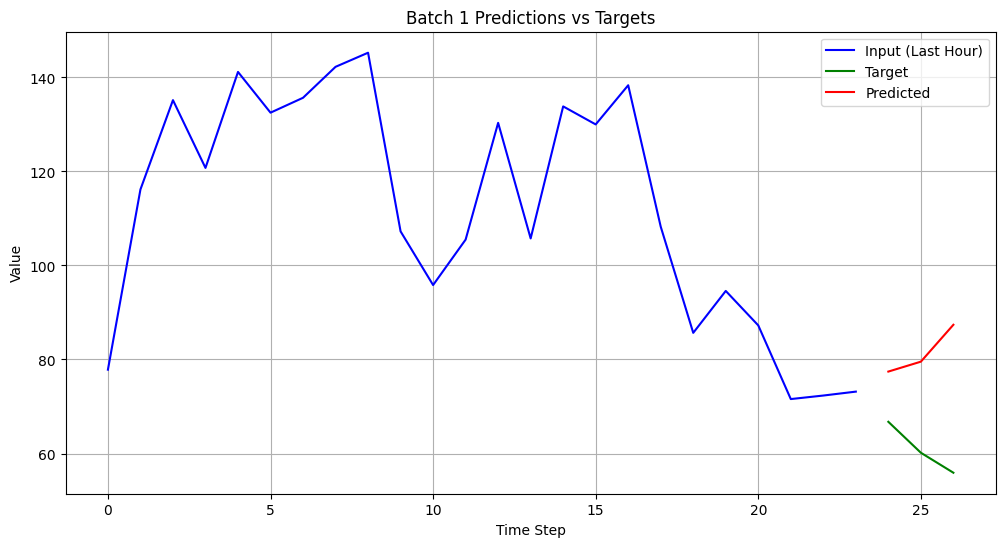

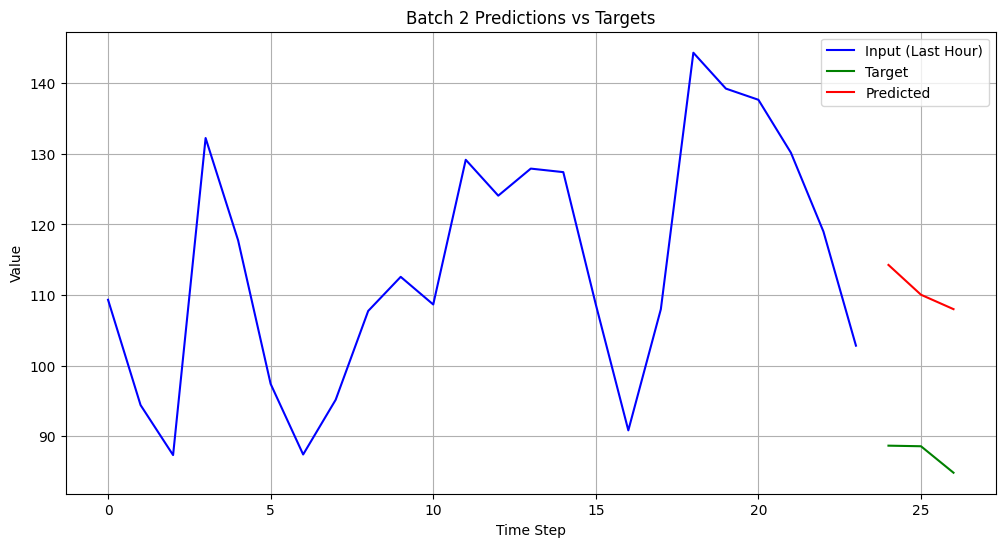

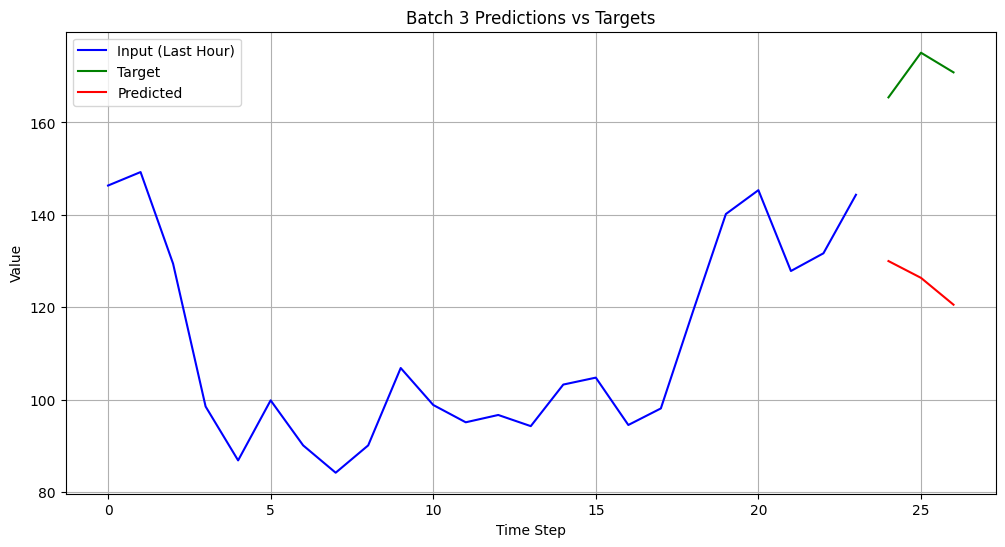

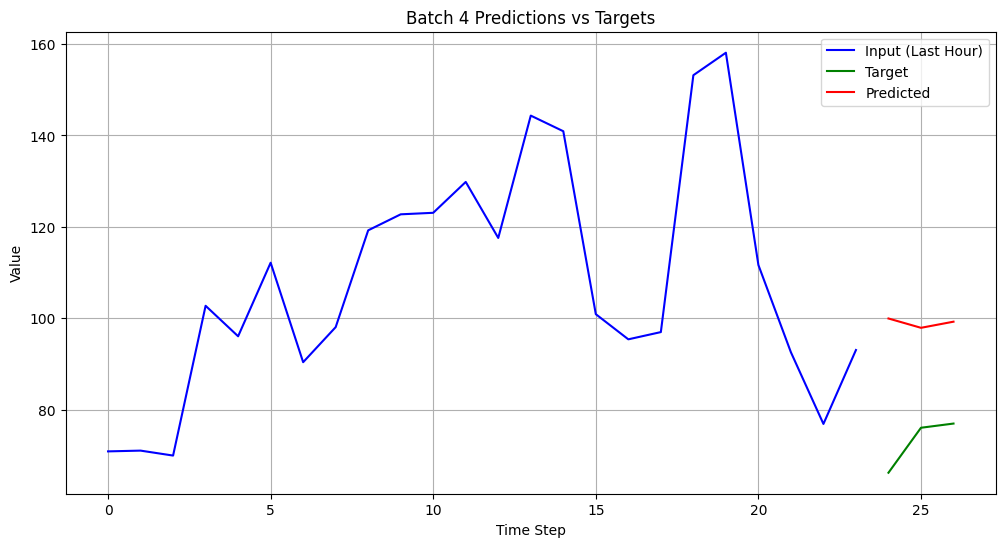

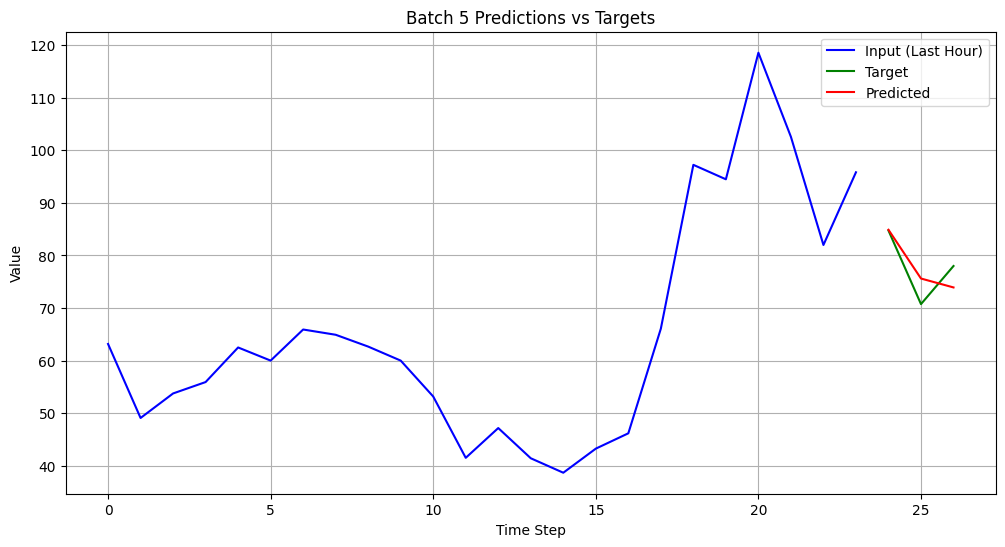

In [23]:
import collections

# Set the model to evaluation mode
seq2seq_model.eval()

# Initialize variables to track loss
loss_value = 0
num_batches = 0

# Define the loss function
criterion = torch.nn.MSELoss()
mae_list = []
visualise_dataset = collections.defaultdict(list)

# Disable gradient computation for validation
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):

        # Forward pass (ensure correct hidden states are passed)
        hidden_state, cell_state = seq2seq_model.encoder(inputs)  # Get encoder hidden states
        decoder_input = inputs  # Use the input as the initial decoder input (you could also use a special token)

        # The decoder will use these hidden states
        output = seq2seq_model.decoder(decoder_input, (hidden_state, cell_state))  # Pass hidden and cell states to the decoder

        # Denormalize predictions and targets (for all 3 time steps)
        output = output.to(device)
        targets = targets.to(device)
        inputs_denorm = inputs * (data_max["Average Taxi Availability"] - data_min["Average Taxi Availability"]) + data_min["Average Taxi Availability"]
        output_denorm = output * (data_max["Average Taxi Availability"] - data_min["Average Taxi Availability"]) + data_min["Average Taxi Availability"]
        targets_denorm = targets * (data_max["Average Taxi Availability"] - data_min["Average Taxi Availability"]) + data_min["Average Taxi Availability"]
        
        visualise_dataset[batch_idx] = inputs_denorm[:,:, 5:6].cpu().numpy()
        # Add targets to visualise_dataset
        visualise_dataset[batch_idx] = np.concatenate((visualise_dataset[batch_idx], targets_denorm.cpu().numpy()), axis=1)
        visualise_dataset[batch_idx] = np.concatenate((visualise_dataset[batch_idx], output_denorm.cpu().numpy()), axis=1)

        # Compute loss on normalized data
        loss_value += criterion(output, targets)
        mae = torch.mean(torch.abs(output_denorm - targets_denorm))
        mae_list.append(mae)
        print(mae)
        # Print a sample of the normalized and denormalized values
        print("Normalized output[0]:", output[0].tolist())  
        print("Normalized target[0]:", targets[0].tolist())  
        print("Denormalized output[0]:", output_denorm[0].tolist())  
        print("Denormalized target[0]:", targets_denorm[0].tolist())  
        print("-" * 50)

# Compute average loss
loss_value = loss_value / (len(test_loader) - 1)
print("Predicted output shape:", output.shape)
print("True output shape:", targets.shape)
print(f'Average Validation Loss: {loss_value:.4f}')

mae = torch.mean(torch.tensor(mae_list))
print(f'Mean Absolute Error: {mae:.4f}')

# Visualize the predictions and targets for the first batch
for batch_idx, data in visualise_dataset.items():
    inputs = data[0, :24]       # First 25 timesteps
    targets = data[0, 24:27]    # 3 timesteps: ground truth
    predictions = data[0, 27:]  # 3 timesteps: model predictions
    plt.figure(figsize=(12, 6))
    # Input: plotted from timestep 0 to 24
    plt.plot(range(24), inputs[:, -1], label='Input (Last Hour)', color='blue')
    # Targets: plotted starting from timestep 24 to 26
    plt.plot(range(24, 27), targets[:, -1], label='Target', color='green')
    # Predictions: plotted from timestep 27 to 29
    plt.plot(range(24, 27), predictions[:, -1], label='Predicted', color='red')
    plt.title(f'Batch {batch_idx} Predictions vs Targets')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()